In [4]:
import copy
import matplotlib.pyplot as plt

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT
from devinterp.slt.learning_coeff import estimate_learning_coeff, estimate_learning_coeff_with_summary
from joblib import Parallel, delayed

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("muted")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("pastel")[:3]

In [5]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in (train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)


# Define the neural network
class Net(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

In [6]:
# DEVICE = "cuda"
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_data))
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Initialize model, loss, optimizer and sgld sampler
model = Net([1024]).to(DEVICE)
criterion = nn.CrossEntropyLoss()
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
n_epochs = 40

60000


In [7]:
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

def rlct_estimate(model, sampling_method=SGLD, summary=False, num_chains=5):
    callable = estimate_learning_coeff_with_summary if summary else estimate_learning_coeff
    if sampling_method == SGLD:
        rlct_estimate = callable(
            copy.deepcopy(model),
            train_loader,
            criterion=criterion,
            optimizer_kwargs=dict(
                lr=1e-5,
                noise_level=1.0,
                elasticity=100.0,
                num_samples=len(train_data),
                temperature="adaptive",
            ),
            sampling_method=sampling_method,
            num_chains=num_chains,
            num_draws=400,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            device=DEVICE,
            verbose=False,
            restrict_to_orth_grad=False,
        )
        rlct_estimate_orth = callable(
            copy.deepcopy(model),
            train_loader,
            criterion=criterion,
            optimizer_kwargs=dict(
                lr=1e-5,
                noise_level=1.0,
                elasticity=100.0,
                num_samples=len(train_data),
                temperature="adaptive",
            ),
            sampling_method=sampling_method,
            num_chains=num_chains,
            num_draws=400,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            device=DEVICE,
            verbose=False,
            restrict_to_orth_grad=True,
        )
    else:
        rlct_estimate = callable(
            copy.deepcopy(model),
            train_loader,
            criterion=criterion,
            optimizer_kwargs=dict(
                lr=1e-7,
                diffusion_factor=0.01,
                num_samples=len(train_data),
            ),
            sampling_method=sampling_method,
            num_chains=num_chains,
            num_draws=400,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            device=DEVICE,
            verbose=False,
        )
        rlct_estimate_orth = callable(
            copy.deepcopy(model),
            train_loader,
            criterion=criterion,
            optimizer_kwargs=dict(
                lr=1e-7,
                diffusion_factor=0.01,
                num_samples=len(train_data),
            ),
            sampling_method=sampling_method,
            num_chains=num_chains,
            num_draws=400,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            device=DEVICE,
            verbose=False,
            restrict_to_orth_grad=True
        )
    
    return rlct_estimate, rlct_estimate_orth

In [8]:
# train model
train_losses = []
test_losses = []
rlct_estimates = []
models = []
# check if model path exists else train model
try:
    models = torch.load("models.pth")
    assert len(models) == n_epochs
    print("Loading model")
except:
    models = []
    print("Training model")
    for epoch in tqdm(range(n_epochs)):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        test_loss = evaluate(model, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        # rlct_estimates.append(rlct_estimate)
        models += [copy.deepcopy(model)]
        # print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")
    # plot losses
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    # make plot larger
    plt.gcf().set_size_inches(16, 8)
    plt.show()
    import os
    os.remove("models.pth")
    torch.save(models, "models.pth")

Loading model


In [9]:
# parallelize the rlct method to populate rlct_estimates
sgld_out = Parallel(n_jobs=-1, verbose=10)(
    delayed(rlct_estimate)(model, SGLD, summary=True) for model in models
)
sgnht_out = Parallel(n_jobs=-1, verbose=10)(
    delayed(rlct_estimate)(model, SGNHT, summary=True) for model in models
)
# sgld_rlct, sgld_rlct_orth = zip(*rlct_estimates_sgld)
# sgnht_rlct, sgnht_rlct_orth = zip(*rlct_estimates_sgnht)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed:  8.5min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed: 12.8min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed: 12.9min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed: 15.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 15.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed:  9.2min remaining:  7.5mi

In [33]:
sgld_out[0]

({'mean': -3835.332763671875,
  'std': 18.834707260131836,
  'chain_0': -3845.2900390625,
  'chain_1': -3841.684814453125,
  'chain_2': -3847.9423828125,
  'chain_3': -3839.6123046875,
  'chain_4': -3802.1337890625,
  'trace':      chain step      loss
  0        0    0  1.301449
  1        0    1  1.278492
  2        0    2  1.305315
  3        0    3  1.291013
  4        0    4  1.294801
  ...    ...  ...       ...
  1995     4  395  0.373138
  1996     4  396  0.322056
  1997     4  397  0.391835
  1998     4  398  0.349473
  1999     4  399  0.359487
  
  [2000 rows x 3 columns]},
 {'mean': -3493.12158203125,
  'std': 26.117630004882812,
  'chain_0': -3477.168701171875,
  'chain_1': -3537.052978515625,
  'chain_2': -3483.68115234375,
  'chain_3': -3495.749755859375,
  'chain_4': -3471.954833984375,
  'trace':      chain step      loss
  0        0    0  1.295891
  1        0    1  1.290884
  2        0    2  1.290923
  3        0    3   1.29096
  4        0    4  1.300344
  ...    

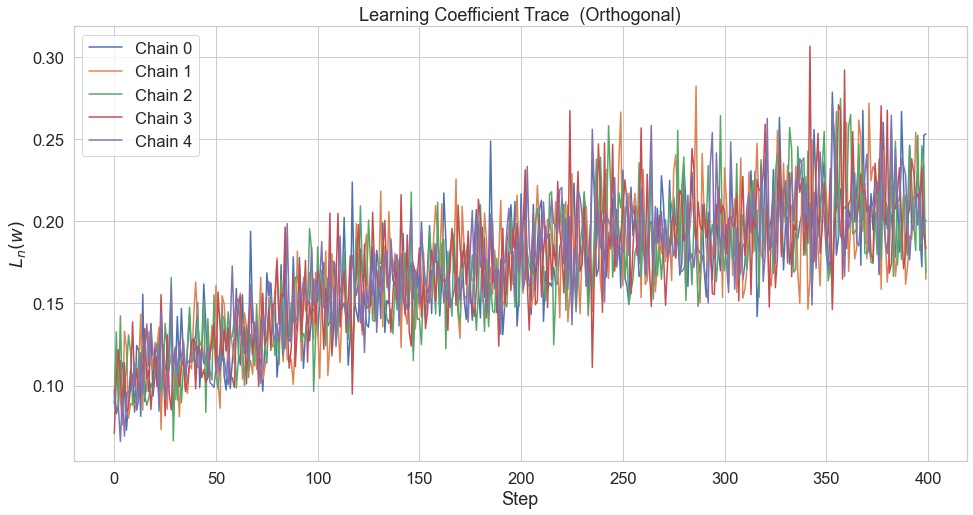

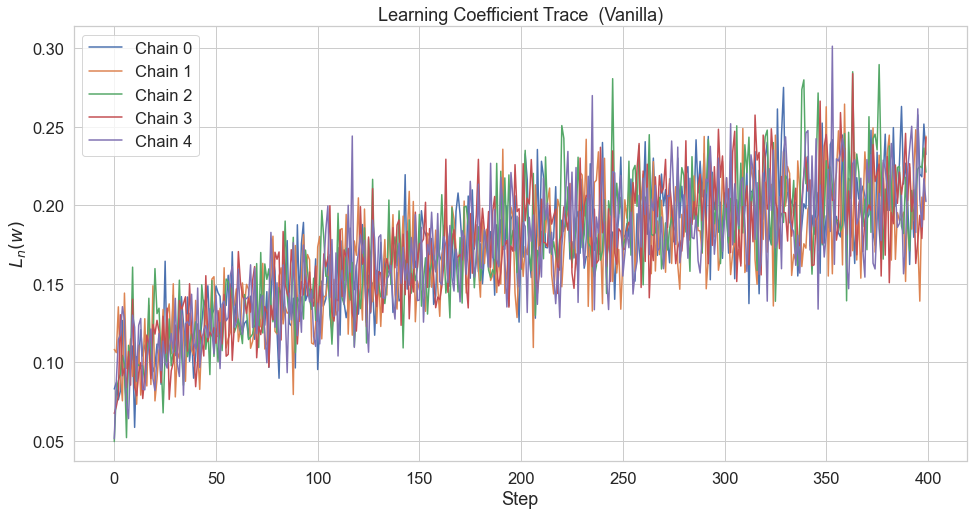

In [50]:
import pandas as pd
def plot_learning_coeff_trace(trace: pd.DataFrame, title_suffix="", **kwargs):
    import matplotlib.pyplot as plt

    for chain, df in trace.groupby("chain"):
        plt.plot(df["step"], df["loss"], label=f"Chain {chain}", **kwargs)

    plt.xlabel("Step")
    plt.ylabel(r"$L_n(w)$")
    plt.title(f"Learning Coefficient Trace {title_suffix}")
    plt.legend()
    plt.gcf().set_size_inches(16, 8)
    plt.show()
# plot learning coefficient trace
plot_learning_coeff_trace(sgld_out[-1][1]["trace"], title_suffix=" (Orthogonal)")
plot_learning_coeff_trace(sgld_out[-1][0]["trace"], title_suffix=" (Vanilla)")

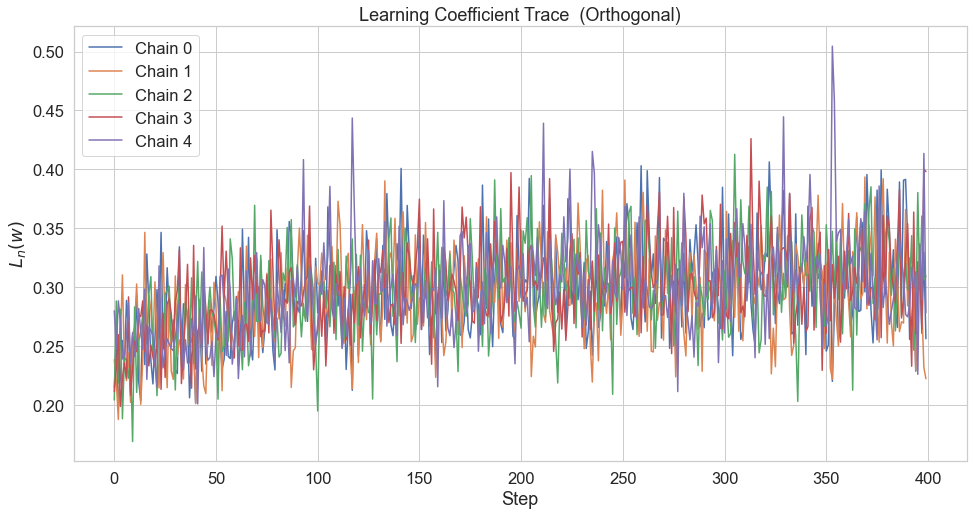

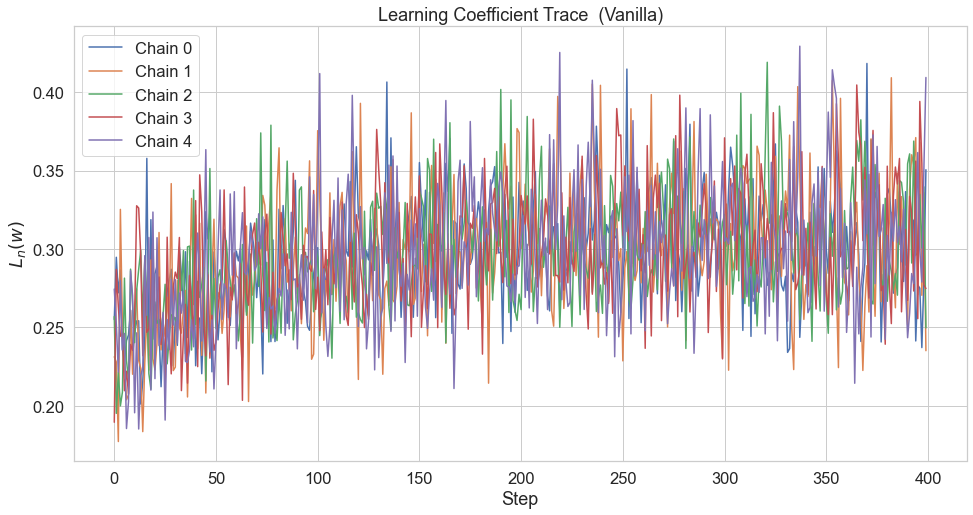

In [51]:
plot_learning_coeff_trace(sgld_out[10][1]["trace"], title_suffix=" (Orthogonal)")
plot_learning_coeff_trace(sgld_out[10][0]["trace"], title_suffix=" (Vanilla)")

In [43]:
sgld_rlct = [sgld_out[i][0]["mean"] for i in range(len(sgld_out))]
sgld_rlct_orth = [sgld_out[i][1]["mean"] for i in range(len(sgld_out))]
sgnht_rlct = [sgnht_out[i][0]["mean"] for i in range(len(sgnht_out))]
sgnht_rlct_orth = [sgnht_out[i][1]["mean"] for i in range(len(sgnht_out))]

In [45]:
sgld_rlct_dev = [sgld_out[i][0]["std"] for i in range(len(sgld_out))]
sgld_rlct_orth_dev = [sgld_out[i][1]["std"] for i in range(len(sgld_out))]
sgnht_rlct_dev = [sgnht_out[i][0]["std"] for i in range(len(sgnht_out))]
sgnht_rlct_orth_dev = [sgnht_out[i][1]["std"] for i in range(len(sgnht_out))]

In [40]:
def get_chain_rlct(rlct_out, i):
    return [rlct_out[i][0][f"chain_{j}"] for j in range(5)]

sgld_chains = [get_chain_rlct(sgld_out, i) for i in range(len(sgld_out))]

In [42]:
sgld_chains[0]

[-3845.2900390625,
 -3841.684814453125,
 -3847.9423828125,
 -3839.6123046875,
 -3802.1337890625]

In [38]:
len(sgld_estimates)

40

In [ ]:
def plot_rlcts(estimated_rlcts, sample_points):
    fig, axes = plt.subplots(1, len(estimated_rlcts), figsize=(14, 3))
    fig.patch.set_facecolor("white")
    for i, (rlct_estimates_sgnht, rlct_estimates_sgld) in enumerate(estimated_rlcts):
        axes[i].set_xlim([-0.5, 1.5])
        axes[i].set_title(rf"$w_1={sample_points[i][0]:.1f}, w_2={sample_points[i][1]:.1f}$")
        axes[i].hist(
            rlct_estimates_sgnht,
            alpha=0.6,
            bins=20,
            range=(-0.5, 1.5),
            label="vanilla",
            color=PRIMARY,
        )
        axes[i].hist(
            rlct_estimates_sgld,
            alpha=0.6,
            bins=20,
            range=(-0.5, 1.5),
            label="orthogonal",
            color=SECONDARY,
        )
        # axes[i].axvline(actual_rlcts[i], color="black", linestyle="--")
        axes[i].set_xlabel(r"$\hat\lambda$")
    axes[0].legend()
    plt.show()

# plot rlcts


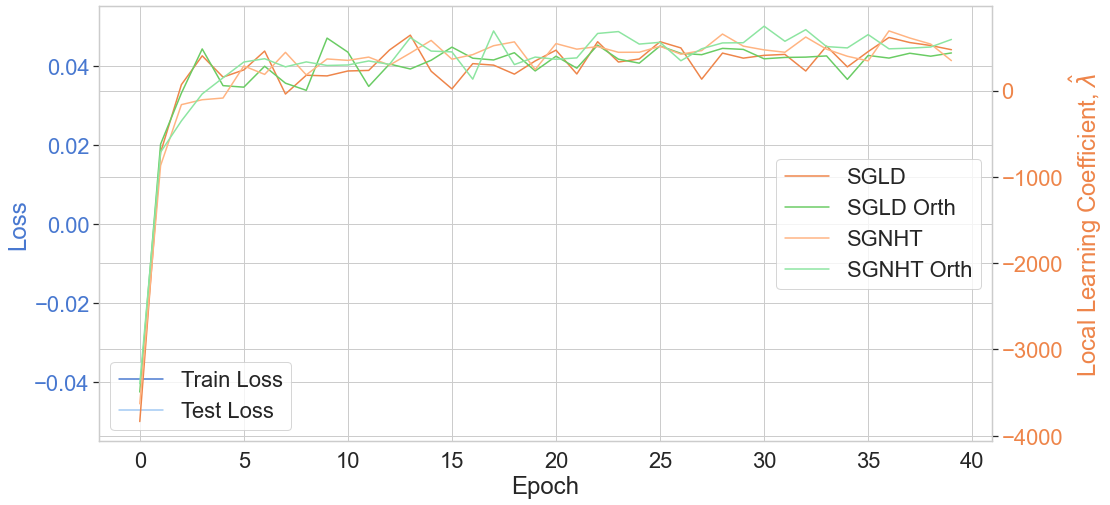

In [44]:
sns.set(font_scale=2)
sns.set_style("whitegrid")

fig, ax1 = plt.subplots()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=PRIMARY)
ax1.plot(train_losses, label="Train Loss", color=PRIMARY)
ax1.plot(test_losses, label="Test Loss", color=PRIMARY_LIGHT)
ax1.tick_params(axis="y", labelcolor=PRIMARY)
ax1.legend(loc="lower left")

ax2 = ax1.twinx()
ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
ax2.plot(sgld_rlct, label="SGLD", color=SECONDARY)
ax2.plot(sgld_rlct_orth, label="SGLD Orth", color=TERTIARY)
ax2.plot(sgnht_rlct, label="SGNHT", color=SECONDARY_LIGHT)
ax2.plot(sgnht_rlct_orth, label="SGNHT Orth", color=TERTIARY_LIGHT)
ax2.tick_params(axis="y", labelcolor=SECONDARY)
ax2.legend(loc="center right")

# fig.tight_layout()
# make figure larger
fig.set_size_inches(16, 8)
# increase font size

# plt.show()

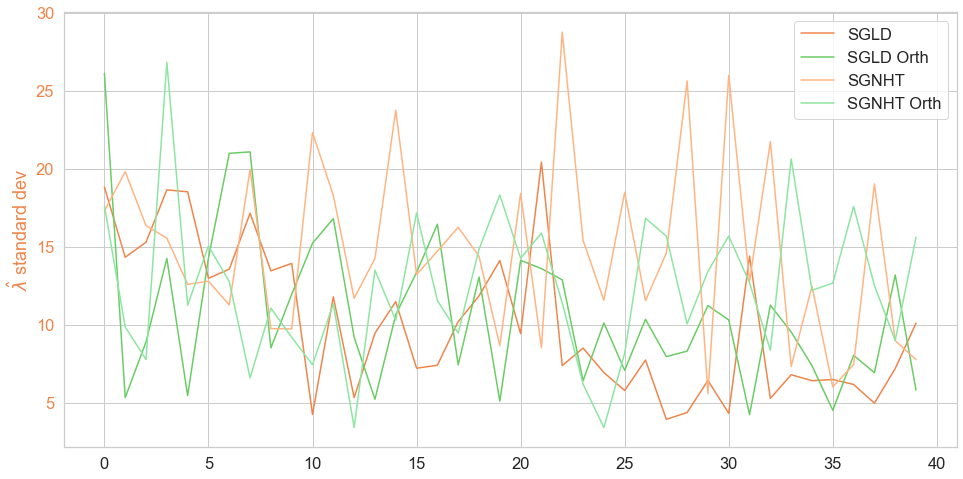

In [49]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

fig, ax1 = plt.subplots()

ax2 = ax1
ax2.set_ylabel(r"$\hat \lambda$ standard dev", color=SECONDARY)
ax2.plot(sgld_rlct_dev, label="SGLD", color=SECONDARY)
ax2.plot(sgld_rlct_orth_dev, label="SGLD Orth", color=TERTIARY)
ax2.plot(sgnht_rlct_dev, label="SGNHT", color=SECONDARY_LIGHT)
ax2.plot(sgnht_rlct_orth_dev, label="SGNHT Orth", color=TERTIARY_LIGHT)
ax2.tick_params(axis="y", labelcolor=SECONDARY)
ax2.legend()

# fig.tight_layout()
# make figure larger
fig.set_size_inches(16, 8)
# increase font size

# plt.show()